In [1]:
!pip install eTaPR-1.12-py3-none-any.whl

In [206]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange
from TaPR_pkg import etapr
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential,load_model
from keras.layers import Concatenate,GRU,LSTM,Dropout,TimeDistributed,Reshape,Input, Conv1D, Lambda, Dense, Flatten,MaxPooling1D, concatenate

## 데이터 전처리

학습 데이터와 테스트 데이터는 CSV로 제공됩니다.
HAI 2.0은 단일 파일이 아니라 여러 파일로 제공되기 때문에 디렉토리 안에 있는 모든 CSV를 읽습니다.

In [207]:
TRAIN_DATASET = sorted([x for x in Path("data/HAI_2.0/training/").glob("*.csv")])
TRAIN_DATASET

[WindowsPath('data/HAI_2.0/training/train1.csv'),
 WindowsPath('data/HAI_2.0/training/train2.csv'),
 WindowsPath('data/HAI_2.0/training/train3.csv')]

In [208]:
VALIDATION_DATASET = sorted([x for x in Path("data/HAI_2.0/validation/").glob("*.csv")])
VALIDATION_DATASET

[WindowsPath('data/HAI_2.0/validation/validation.csv')]

In [209]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    len_train=[]
    for x in targets:
        len_train.append(dataframe_from_csv(x).shape[0])
    return pd.concat([dataframe_from_csv(x) for x in targets]),len_train

In [210]:
TRAIN_DF_RAW,len_Train = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,...,944.84705,0.0,1.32843,15.17817,35.14710,11.79657,316.89453,296.54950,32.0000,6.6026
478797,2020-08-10 10:59:57,387.52774,12,10,66.72057,-0.9996,-1.84479,787.65070,28.02385,840.0,...,940.49835,0.0,1.32843,15.17344,35.13183,11.79657,315.59247,296.15161,32.0000,6.3894
478798,2020-08-10 10:59:58,387.47665,12,10,66.72057,-1.2560,-1.84479,788.50256,28.03085,792.0,...,935.71472,0.0,1.32919,15.16443,35.13183,11.79657,313.92865,293.40277,32.0000,6.2584
478799,2020-08-10 10:59:59,387.73221,12,10,66.72057,-1.4912,-1.84479,785.80316,28.02649,752.0,...,944.84705,0.0,1.32843,15.09001,35.14710,11.79657,315.61054,302.58972,32.0000,6.4150


In [211]:
len_Train

[216001, 226801, 478801]

In [212]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [213]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [214]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [215]:
TRAIN_np=TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].values

In [216]:
TRAIN_DF_norm = normalize(
    TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()


In [217]:
TRAIN_np_norm=TRAIN_DF_norm.values

In [218]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [219]:
boundary_check(TRAIN_np)

(True, True, False)

In [220]:
boundary_check(TRAIN_np_norm)

(False, False, False)

In [221]:
TRAIN_np_norm.shape

(921603, 79)

In [158]:
#train_data

#editable parameter

#window_size : Amount of data referenced for prediction

#stride : skip parameter , A variable used because the value of the data does not change significantly.
#If the stride is 10, parsing the data by skipping 10 times.

window_size = 30
stride= 10
X, Y = [], []
skip=0
for i in len_Train:
    n_window = i-window_size+1
    per=int(n_window/100)
    for w in range(int((n_window-1)/stride)):
        X.append(TRAIN_np_norm[skip+w*stride : skip+ w*stride+window_size])
        Y.append(TRAIN_np_norm[skip+w*stride+window_size])
        if w%per==0:
            print(str(int(w*stride/per * 100)/100)+"%")
    skip=skip+i
            
print("Start list to array")
X, Y = np.asarray(X), np.asarray(Y)
print(X.shape,Y.shape)
print("Done")

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
Start list to array
(92151, 30, 79) (92151, 79)
Done


In [159]:
VALIDATION_DF_RAW,len_Val = dataframe_from_csvs(VALIDATION_DATASET)

In [160]:
VALIDATION_DF_RAW["time"]

0        2020-07-07 15:00:00
1        2020-07-07 15:00:01
2        2020-07-07 15:00:02
3        2020-07-07 15:00:03
4        2020-07-07 15:00:04
                ...         
43196    2020-07-08 02:59:56
43197    2020-07-08 02:59:57
43198    2020-07-08 02:59:58
43199    2020-07-08 02:59:59
43200    2020-07-08 03:00:00
Name: time, Length: 43201, dtype: object

In [161]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [162]:
VALIDATION_np_norm=VALIDATION_DF.values

In [163]:
boundary_check(VALIDATION_np_norm)

(True, True, False)

In [164]:
#validation

# Don't edit

stride_val= 1
n_window_val = VALIDATION_np_norm.shape[0]-window_size+1
X_val, Y_val = [], []
per_val=int(n_window_val/100)

for j in len_Val:
    n_window_val = j-window_size+1
    per=int(n_window_val/100)
    for w in range(int((n_window_val-1)/stride_val)):
        X_val.append(VALIDATION_np_norm[w*stride_val : w*stride_val+window_size])
        Y_val.append(VALIDATION_np_norm[w*stride_val+window_size])
        if w%per_val==0:
            print(str((int(w*stride_val/per_val * 100)/100))+"%")

        
print("Start list to array")
X_val, Y_val = np.asarray(X_val), np.asarray(Y_val)
print(X_val.shape,Y_val.shape)
print("Done")

0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
100.0%
Start list to array
(43171, 30, 79) (43171, 79)
Done


# DATA preprocessing End

#DATA Train Start

In [165]:
b_input = Input(shape=(X[0].shape))
H = LSTM(64, return_sequences=True)(b_input)
#H = LSTM(256, return_sequences=True)(H)
#H = LSTM(256, return_sequences=True)(H)
#H = LSTM(256, return_sequences=True)(H)
#H = LSTM(256, return_sequences=True)(H)
#H = LSTM(256, return_sequences=True)(H)
#H = LSTM(256, return_sequences=True)(H)
H = LSTM(64, return_sequences=False)(H)
H = Dense(128, activation='tanh')(H)
H = Dense(128, activation='tanh')(H)
b_output = Dense(79, activation='linear')(H)

In [166]:
model_cnn_lstm_base = Model(b_input, b_output)
model_cnn_lstm_base.compile(loss='mse', optimizer='adam', metrics=['mse', 'kullback_leibler_divergence','MAPE','MAE'])
model_cnn_lstm_base.summary()
es = EarlyStopping(monitor='loss', restore_best_weights=True, patience=20)
model_cnn_lstm_base.fit(X, Y, validation_data=(X_val, Y_val), epochs=20000, batch_size=2048, shuffle=True, callbacks=[es])

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 30, 79)            0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 30, 64)            36864     
_________________________________________________________________
lstm_53 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_56 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_57 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_58 (Dense)             (None, 79)                10191     
Total params: 104,911
Trainable params: 104,911
Non-trainable params: 0
____________________________________________________

92151/92151 [==============================] - 4s 46us/step - loss: 8.0562e-04 - mse: 8.0562e-04 - kullback_leibler_divergence: 0.1563 - MAPE: 2038513.8750 - MAE: 0.0161 - val_loss: 0.0022 - val_mse: 0.0022 - val_kullback_leibler_divergence: 0.6461 - val_MAPE: 2619755.2500 - val_MAE: 0.0217
Epoch 25/20000
92151/92151 [==============================] - 4s 46us/step - loss: 7.8073e-04 - mse: 7.8073e-04 - kullback_leibler_divergence: 0.1513 - MAPE: 1945323.1250 - MAE: 0.0157 - val_loss: 0.0021 - val_mse: 0.0021 - val_kullback_leibler_divergence: 0.7367 - val_MAPE: 2451712.7500 - val_MAE: 0.0212
Epoch 26/20000
92151/92151 [==============================] - 4s 45us/step - loss: 7.5488e-04 - mse: 7.5488e-04 - kullback_leibler_divergence: 0.1452 - MAPE: 1870188.0000 - MAE: 0.0152 - val_loss: 0.0021 - val_mse: 0.0021 - val_kullback_leibler_divergence: 0.7447 - val_MAPE: 2527364.0000 - val_MAE: 0.0214
Epoch 27/20000
92151/92151 [==============================] - 4s 45us/step - loss: 7.3905e-04 

Epoch 51/20000
92151/92151 [==============================] - 4s 45us/step - loss: 5.8119e-04 - mse: 5.8119e-04 - kullback_leibler_divergence: 0.1037 - MAPE: 1156667.8750 - MAE: 0.0118 - val_loss: 0.0017 - val_mse: 0.0017 - val_kullback_leibler_divergence: 0.6106 - val_MAPE: 1634410.8750 - val_MAE: 0.0169
Epoch 52/20000
92151/92151 [==============================] - 4s 46us/step - loss: 5.7791e-04 - mse: 5.7791e-04 - kullback_leibler_divergence: 0.1047 - MAPE: 1148068.5000 - MAE: 0.0118 - val_loss: 0.0017 - val_mse: 0.0017 - val_kullback_leibler_divergence: 0.6879 - val_MAPE: 1539287.7500 - val_MAE: 0.0168
Epoch 53/20000
92151/92151 [==============================] - 4s 45us/step - loss: 5.8322e-04 - mse: 5.8322e-04 - kullback_leibler_divergence: 0.1098 - MAPE: 1157903.7500 - MAE: 0.0120 - val_loss: 0.0017 - val_mse: 0.0017 - val_kullback_leibler_divergence: 0.4848 - val_MAPE: 1626864.1250 - val_MAE: 0.0164
Epoch 54/20000
92151/92151 [==============================] - 4s 46us/step - lo

Epoch 78/20000
92151/92151 [==============================] - 4s 45us/step - loss: 5.1929e-04 - mse: 5.1929e-04 - kullback_leibler_divergence: 0.0966 - MAPE: 1013669.1250 - MAE: 0.0110 - val_loss: 0.0015 - val_mse: 0.0015 - val_kullback_leibler_divergence: 0.2239 - val_MAPE: 1604404.2500 - val_MAE: 0.0155
Epoch 79/20000
92151/92151 [==============================] - 4s 45us/step - loss: 5.1364e-04 - mse: 5.1364e-04 - kullback_leibler_divergence: 0.0880 - MAPE: 984415.5000 - MAE: 0.0107 - val_loss: 0.0015 - val_mse: 0.0015 - val_kullback_leibler_divergence: 0.5386 - val_MAPE: 1289676.5000 - val_MAE: 0.0151
Epoch 80/20000
92151/92151 [==============================] - 4s 45us/step - loss: 5.1256e-04 - mse: 5.1256e-04 - kullback_leibler_divergence: 0.0948 - MAPE: 972123.5625 - MAE: 0.0108 - val_loss: 0.0015 - val_mse: 0.0015 - val_kullback_leibler_divergence: 0.4064 - val_MAPE: 1283227.8750 - val_MAE: 0.0147
Epoch 81/20000
92151/92151 [==============================] - 4s 45us/step - loss

KeyboardInterrupt: 

In [167]:
y_val_predict = model_cnn_lstm_base.predict(X_val)

In [168]:
DIST=np.abs(y_val_predict-Y_val)

In [169]:
DIST.shape

(43171, 79)

In [170]:
CHECK_ATT=VALIDATION_DF_RAW["attack"]

In [171]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

In [172]:
ANOMALY_SCORE = np.max(DIST,axis=1)

In [173]:
ANOMALY_SCORE

array([0.11278514, 0.14862037, 0.16305911, ..., 0.0838848 , 0.12133086,
       0.10213593])

In [174]:
blank_for_NAN=np.zeros(window_size)
ANOMALY_SCORE_for_graph=np.concatenate((blank_for_NAN,ANOMALY_SCORE),axis=0)


inference 함수는 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록합니다.

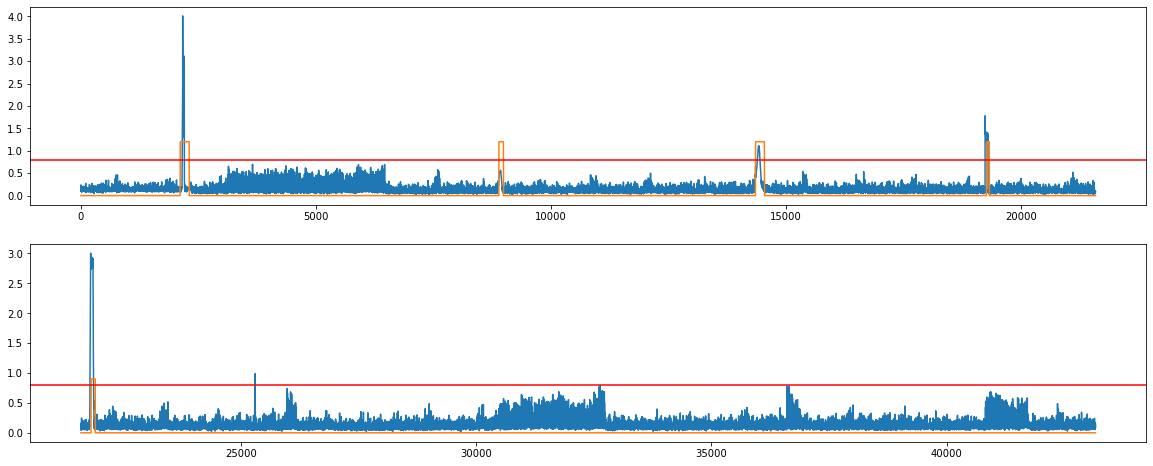

In [176]:
THRESHOLD = 0.8
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

주황색 선은 공격 위치를 나타내고, 파란색 선은 (평균) 오차의 크기를 나타냅니다.
전반적으로 공격 위치에서 큰 오차를 보이고 있습니다.

임의의 threshold(빨간색 선)가 넘어갈 경우 공격으로 간주합니다.
공격은 1로 정상은 0으로 표기합니다.

In [177]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

위의 그래프를 보면 대략 0.04를 기준으로 설정할 수 있을 것으로 보입니다.
여러 번의 실험을 통해 정밀하게 임계치를 선택하면 더 좋은 결과를 얻을 수 있을 것으로 예상합니다.

In [178]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (43171,))

In [179]:
list(LABELS).count(1)

241

정답지(ATTACK_LABELS)도 동일하게 추출합니다.
검증 데이터셋에 공격 여부를 나타내는 필드에는 정상을 0으로 공격을 1로 표기하고 있습니다.
위에 정의한 put_labels 함수를 이용해서 0.5를 기준으로 같은 방식으로 TaPR을 위한 label을 붙여줍니다.

In [180]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), (43201,))

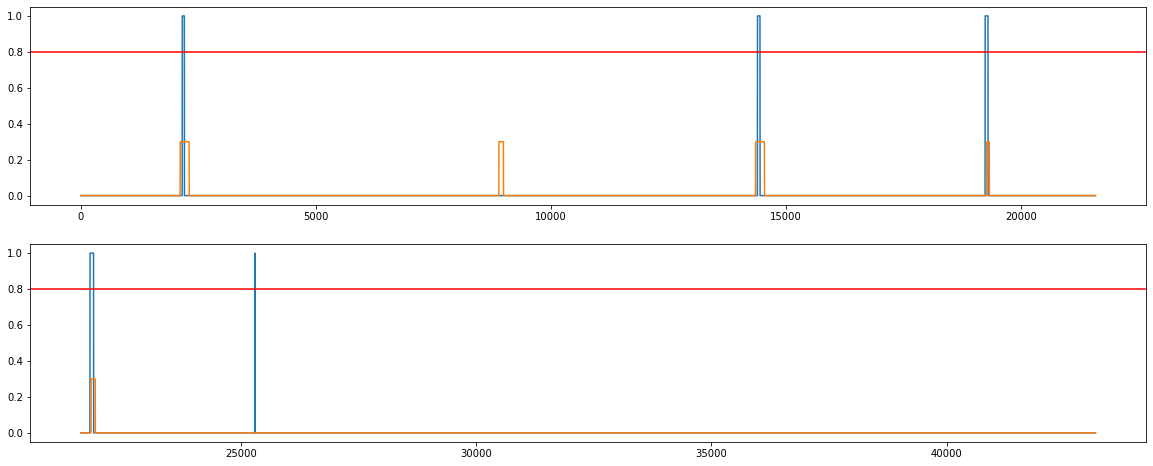

In [181]:
check_graph(LABELS, ATTACK_LABELS, piece=2, THRESHOLD=THRESHOLD)

In [182]:
blank_for_NAN=np.zeros(window_size)
Final_Labels=np.concatenate((blank_for_NAN,LABELS),axis=0)


## 평가

평가는 TaPR을 사용합니다.
정답(ATTACK_LABELS)과 모델의 결과(FINAL_LABELS)의 길이가 같은지 확인합니다.

In [185]:
ATTACK_LABELS.shape[0] == Final_Labels.shape[0]

True

TaPR 점수를 받습니다.

In [186]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=Final_Labels)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.770 (TaP: 0.969, TaR: 0.639)
# of detected anomalies: 4
Detected anomalies: ['1', '3', '4', '5']


In [187]:
TEST_DATASET = sorted([x for x in Path("data/HAI_2.0/testing/").glob("*.csv")])
TEST_DATASET

[WindowsPath('data/HAI_2.0/testing/test1.csv'),
 WindowsPath('data/HAI_2.0/testing/test2.csv'),
 WindowsPath('data/HAI_2.0/testing/test3.csv'),
 WindowsPath('data/HAI_2.0/testing/test4.csv')]

In [188]:
TEST_DF_RAW, len_test = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,...,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,...,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,...,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,...,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,...,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,2020-07-31 12:29:56,420.08923,12.0,10,48.31848,-0.8706,97.19238,786.54382,28.03253,232,...,824.82147,100.0,1.35666,9.62203,36.47460,11.78894,357.27722,361.14728,32.0,6.2809
92397,2020-07-31 12:29:57,420.08923,12.0,10,48.31848,-0.7498,97.19238,784.07184,28.03598,224,...,823.51697,100.0,1.35513,9.48747,36.47460,11.78894,357.29529,359.84521,32.0,6.3602
92398,2020-07-31 12:29:58,420.24258,12.0,10,48.31848,-0.6076,97.19238,786.83881,28.02642,208,...,824.82147,100.0,1.35666,9.57787,36.48986,11.78894,357.27722,360.60474,32.0,6.3742
92399,2020-07-31 12:29:59,420.24258,12.0,10,48.31848,-0.4618,97.19238,786.66138,28.03341,200,...,833.51904,100.0,1.35513,9.56291,36.48986,11.78894,357.80170,357.42188,32.0,6.2864


In [189]:
len_test

[118801, 108001, 39601, 92401]

In [190]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.273715,0.0,0.0,0.828325,0.225882,0.000999,0.318761,0.333825,0.010417,0.139867,...,0.677723,0.0,0.317842,0.452044,0.236483,0.944440,0.225971,0.200389,0.26162,0.714722
1,0.273715,0.0,0.0,0.828325,0.171634,0.000999,0.300187,0.426398,0.010417,0.137445,...,0.680584,0.0,0.317842,0.450701,0.230344,0.944440,0.223121,0.198499,0.26162,0.650106
2,0.272825,0.0,0.0,0.828325,0.166747,0.000930,0.298514,0.434738,0.010417,0.137227,...,0.678007,0.0,0.318290,0.451229,0.229791,0.944440,0.220223,0.196880,0.26162,0.644285
3,0.273182,0.0,0.0,0.828325,0.158478,0.000992,0.353980,0.482056,0.010417,0.190063,...,0.675769,0.0,0.318335,0.449470,0.229736,0.944440,0.218893,0.193823,0.26162,0.583093
4,0.272773,0.0,0.0,0.828325,0.174269,0.000998,0.370123,0.556914,0.010417,0.266280,...,0.682626,0.0,0.317891,0.450884,0.229731,0.944440,0.212932,0.198888,0.26162,0.523348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,0.619520,0.0,0.0,0.073426,0.532147,0.998079,0.476720,0.581066,0.017489,0.358745,...,0.596406,1.0,0.319337,0.285888,0.790598,0.083339,0.466152,0.485809,0.26162,0.622130
92397,0.619561,0.0,0.0,0.073426,0.581096,0.998079,0.446527,0.680775,0.016853,0.386044,...,0.595956,1.0,0.318439,0.281450,0.790543,0.083339,0.466370,0.482229,0.26162,0.658390
92398,0.620899,0.0,0.0,0.073426,0.639210,0.998079,0.474916,0.436791,0.015748,0.453718,...,0.596761,1.0,0.319252,0.284110,0.796619,0.083339,0.466330,0.484406,0.26162,0.666539
92399,0.621033,0.0,0.0,0.073426,0.699587,0.998079,0.475741,0.598077,0.015116,0.563381,...,0.602505,1.0,0.318431,0.283862,0.797227,0.083339,0.468106,0.474004,0.26162,0.638988


In [204]:
test_df = TEST_DF.values

In [205]:
test_df.shape

(358804, 79)

In [223]:
test_df

array([[0.27371536, 0.        , 0.        , ..., 0.20038876, 0.26161984,
        0.71472161],
       [0.27371536, 0.        , 0.        , ..., 0.19849945, 0.26161984,
        0.6501059 ],
       [0.27282544, 0.        , 0.        , ..., 0.19687971, 0.26161984,
        0.64428466],
       ...,
       [0.6208987 , 0.        , 0.        , ..., 0.48440553, 0.26161984,
        0.66653899],
       [0.62103251, 0.        , 0.        , ..., 0.47400371, 0.26161984,
        0.6389876 ],
       [0.62149084, 0.        , 0.        , ..., 0.47706646, 0.26161984,
        0.55568897]])

In [228]:
window_size = 30
stride= 1
X_test, Y_test = [], []
skip=0
for i in len_test:
    n_window = i-window_size+1
    per=int(n_window/100)
    for w in range(int((n_window-1)/stride)):
        X_test.append(test_df[skip+w*stride :skip+w*stride+window_size])
        Y_test.append(test_df[skip+w*stride+window_size])
        
    skip=skip+i
            
print("Start list to array")
X_test, Y_test = np.asarray(X_test), np.asarray(Y_test)
print(X_test.shape,Y_test.shape)
print("Done")

Start list to array
(358684, 30, 79) (358684, 79)
Done


In [229]:
y_test_predict = model_cnn_lstm_base.predict(X_test)

In [230]:
test_DIST=np.abs(y_test_predict-Y_test)

In [231]:
test_DIST.shape

(358684, 79)

In [283]:
ANOMALY_test_SCORE = np.max(test_DIST,axis=1)

In [284]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

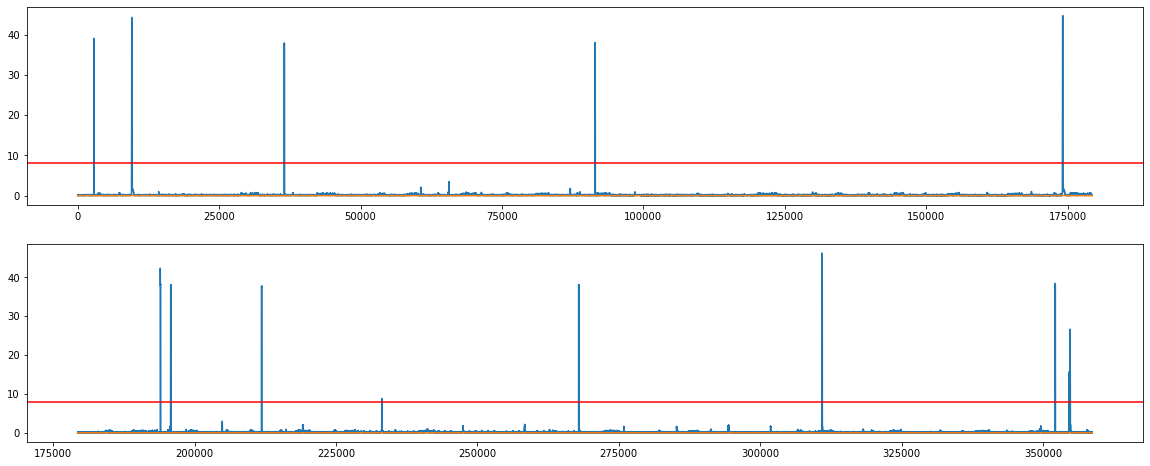

In [301]:
check_graph(ANOMALY_test_SCORE,np.zeros(len(ANOMALY_test_SCORE)),piece=2, THRESHOLD=8)

In [302]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [320]:
label_test=put_labels(ANOMALY_test_SCORE,8)

In [321]:
label_test, label_test.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (358684,))

In [322]:
len(TEST_DF)

358804

In [323]:
dummy = np.zeros(30)

In [324]:
label_test = np.concatenate((dummy,label_test), axis=0)

In [325]:
label_test.shape

(358714,)

In [326]:
len_test

[118801, 108001, 39601, 92401]

In [327]:
label_test = np.concatenate((label_test[:118801],dummy,label_test[118801:]), axis=0)

In [328]:
label_test.shape

(358744,)

In [329]:
label_test = np.concatenate((label_test[:118801+108001],dummy,label_test[118801+108001:]), axis=0)

In [330]:
label_test.shape

(358774,)

In [331]:
label_test = np.concatenate((label_test[:118801+108001+39601],dummy,label_test[118801+108001+39601:]), axis=0)

In [332]:
label_test.shape

(358804,)

In [333]:
# 예측한 결과를 제출양식에 맞춰 저장합니다.

submission = pd.read_csv('data/HAI_2.0/sample_submission.csv')
submission.index = submission['time']
submission['attack'] = label_test
submission
# 예측한 결과를 저장하여 제출합니다.

submission.to_csv('baseline2.csv', index=False)

In [334]:
submission['attack'].shape

(358804,)

In [335]:
label_test.count(1)

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [ ]:
list(label_test).count(1)